# Demo example: filling gaps

This example serves as a demonstration of how to fill gaps. We demonstrate this for temperature observations. First we import the demo data, then we introduce some gaps in them, and as a last step the gaps are filled.

In [1]:
import metobs_toolkit
dataset = metobs_toolkit.Dataset() #Create a new dataset object

#Load the data
dataset.import_data_from_file(
                    template_file=metobs_toolkit.demo_template, #The template file
                    input_data_file=metobs_toolkit.demo_datafile, #The data file
                    input_metadata_file=metobs_toolkit.demo_metadatafile, #The metadata file
                    )


Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.
Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.
Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.
Rukwind is present in the datafile, but not found in the template! This column will be ignored.
Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.
Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.
The following columns are present in the data file, but not in the template! They are skipped!
 ['Luchtdruk', 'Rukwind', 'Neerslagintensiteit', 'Neerslagsom', 'Globe Temperatuur', 'Luchtdruk_Zeeniveau']
The following columns are found in the metadata, but not in the template and are therefore ignored: 
['sponsor', 'Network', 'stad', 'benaming']


## Identifying gaps

As was shown in the [introduction notebook](introduction.ipynb), gaps are constructed when:

* raw data is imported
* `resample()` or `Dataset.sync_records()` is applied

And we can inspect the gaps by plotting timeseries with ``make_plot(colorby='label')``, or via the dataframe attribute `gapsdf`. Both methods work on Dataset-level as on Station-level.


<Axes: title={'center': 'temp data.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

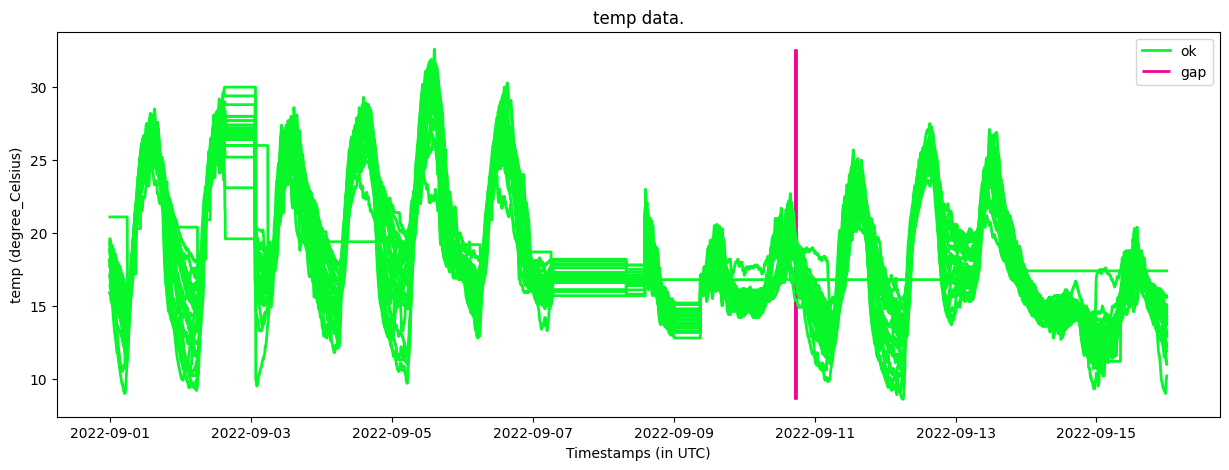

In [2]:
dataset.make_plot(obstype='temp', colorby='label')

As can be seen in the plot, the number of gaps is rather limited. But it is clear that there are some issues with the observations. A common approach is to apply a quality control (QC) pipeline, and interpret the outliers as gaps. 

In the toolkit we can run a QC pipeline, see the [QC introduction](qc_example.ipynb), and then use the `.convert_outliers_to_gaps()` method to convert them to gaps. This is another method to introduce gaps in the dataset.


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/src/metobs_toolkit/qc_collection/repetitions_check.py:64: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/src/metobs_toolkit/qc_collection/repetitions_check.py:64: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/src/metobs_toolkit/qc_collection/repetitions_check.py:64: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thov

<Axes: title={'center': 'After quality control on temperature observations.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

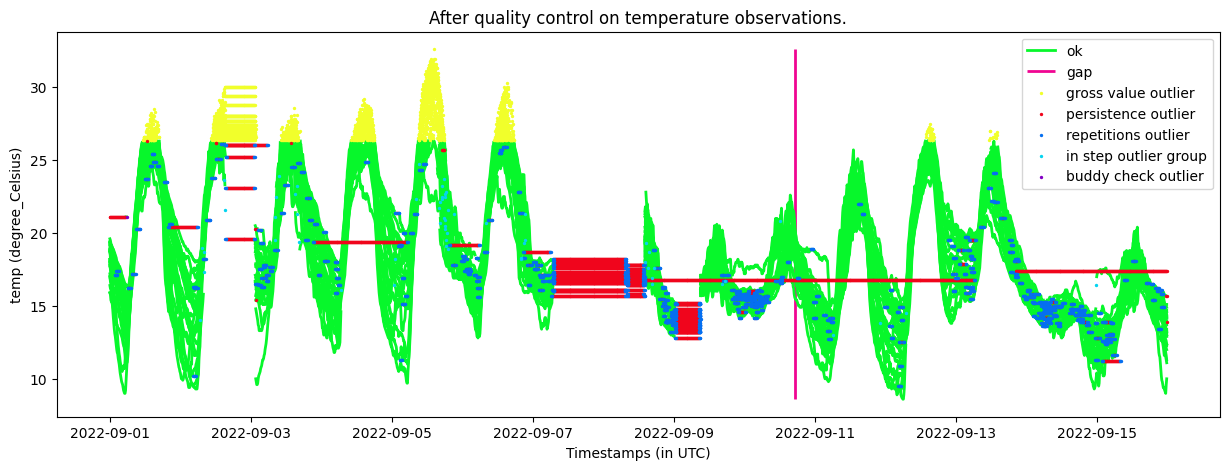

In [3]:
#Apply quality control on temperature (source: the QC introduction)
target = 'temp'
#Resampling
dataset.resample(target_freq='10min')

#1. gross value check
dataset.gross_value_check(
            target_obstype=target,
            lower_threshold=-10.0,
            upper_threshold=26.3)

#2. persistence check
dataset.persistence_check(
            target_obstype=target,
            timewindow='60min',
            min_records_per_window=3)

#3. repetitions check
dataset.repetitions_check(
            target_obstype=target,
            max_N_repetitions=5
)

#4. repetitions check
dataset.step_check(
            target_obstype=target,
            max_increase_per_second = 8.0 / 3600.0, #depends on standard unit! 
            max_decrease_per_second = -10.0 / 3600.0) #depends on standard unit! 

#5. window variation check
dataset.window_variation_check(
            target_obstype=target,
            timewindow='60min',
            min_records_per_window=3,
            max_increase_per_second=8.0 / 3600.0, #depends on standard unit! 
            max_decrease_per_second = -10.0 / 3600.0, #depends on standard unit! 
            )
#6. buddy check
dataset.buddy_check(
        target_obstype=target,
        #main check settings
        spatial_buddy_radius=15000, #15km definition of buddy radius
        spatial_z_threshold=2.0, #outlier threshold
        #requirements
        min_sample_size=5,
        max_alt_diff=None,  # Maximum elevation difference between stations
        N_iter=3, #Number of iterations
        instantaneous_tolerance='4min', #Max timestamp tolerance for 'at the same time'
        lapserate=None, #Specify the variation with altitude, if None no correction is applied
        min_std=1.0,  # Minimum standart deviation
)

dataset.make_plot(obstype='temp', 
                  colorby='label',
                  title='After quality control on temperature observations.')


Now we convert all the temperature outliers to gaps. 

*Note*: The outliers are removed, so the QC frequency statistics information is lost.


<Axes: title={'center': 'Temperature QC outliers are converted to gaps.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

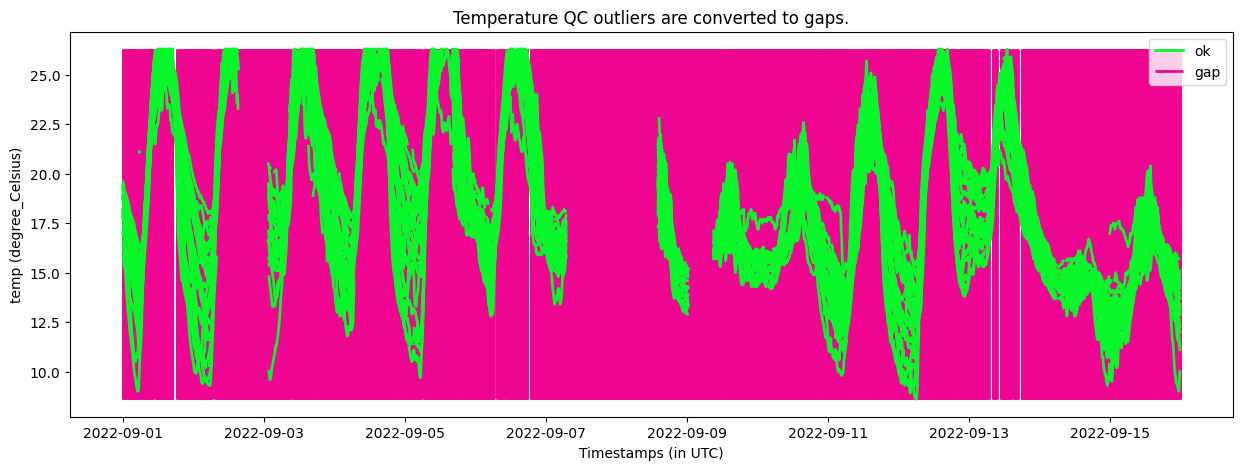

In [4]:
#convert all outliers to gaps
dataset.convert_outliers_to_gaps(obstype='temp')

#Inspect the gaps in a plot
dataset.make_plot(obstype='temp',
                  colorby='label',
                  title='Temperature QC outliers are converted to gaps.')

Since there are many gaps, for different stations, it is more clear to plot the time series of as single station. 

<Axes: title={'center': 'temp data for station vlinder02'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

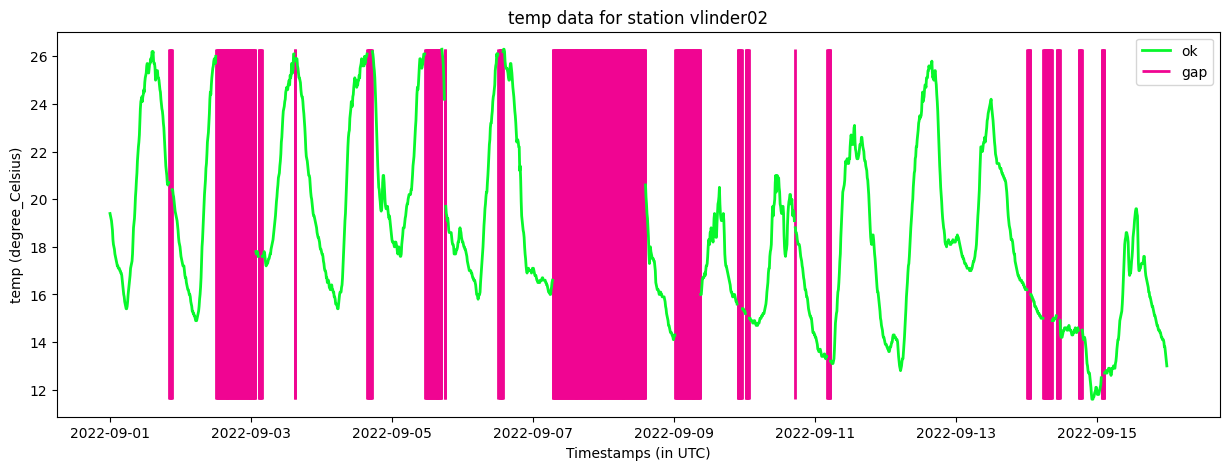

In [5]:
dataset.get_station('vlinder02').make_plot(obstype='temp',
                                           colorby='label')

We now have a dataset with gaps that can be filled.

## Inspecting a gap in detail

The gaps are stored as a list of ``Gap`` instances, in the `SensorData`. We can acces them like:

In [6]:
#Get one specific gap
specific_gap = (dataset
                .get_station('vlinder02') #select a target stations
                .get_sensor('temp') #select a target sensordata
                .gaps[0] #select the first of the stored gaps
                )

specific_gap.get_info()

                              General info of Gap                               


--- Gap details ---

Gap of temp for station: vlinder02
  -From 2022-09-01 20:10:00+00:00 -> 2022-09-01 21:00:00+00:00
  -Duration gap: 0 days 00:50:00

--- Gap filling details ---

  -Gap status: unfilled
  -Gapfill settings used:



Often it is more convenient to use the `gapsdf` attribute:

In [7]:
dataset.get_station('vlinder02').gapsdf

,,value,label,details
datetime,obstype,,,
2022-09-01 20:10:00+00:00,temp,NaN,gap,no details
2022-09-01 20:20:00+00:00,temp,NaN,gap,no details
2022-09-01 20:30:00+00:00,temp,NaN,gap,no details
2022-09-01 20:40:00+00:00,temp,NaN,gap,no details
2022-09-01 20:50:00+00:00,temp,NaN,gap,no details
...,...,...,...,...
2022-09-15 01:50:00+00:00,temp,NaN,gap,no details
2022-09-15 02:00:00+00:00,temp,NaN,gap,no details
2022-09-15 02:10:00+00:00,temp,NaN,gap,no details


These missing observations are indicated in time series plots as vertical lines:

## Fill gaps

In the toolkit, two groups of methods are implemented: **interpolation methods** and by making **use of external modeldata**. 

**NOTE**: In this example, we use a single station (vlinder02) for demonstration. All methods can be directly applied on 
a Dataset, you do not need to apply this on all stations separately.

### Interpolation methods

The most straightforward method to fill a gap is by using interpolation. Linear interpolation is the best-known form of interpolation, but there are also more advanced forms of interpolation. In the toolkit, we can easily interpolate the gaps by making use of the ``.interpolate_gaps()`` method.

<Axes: title={'center': 'Applying linear interpolation to fill the gaps.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

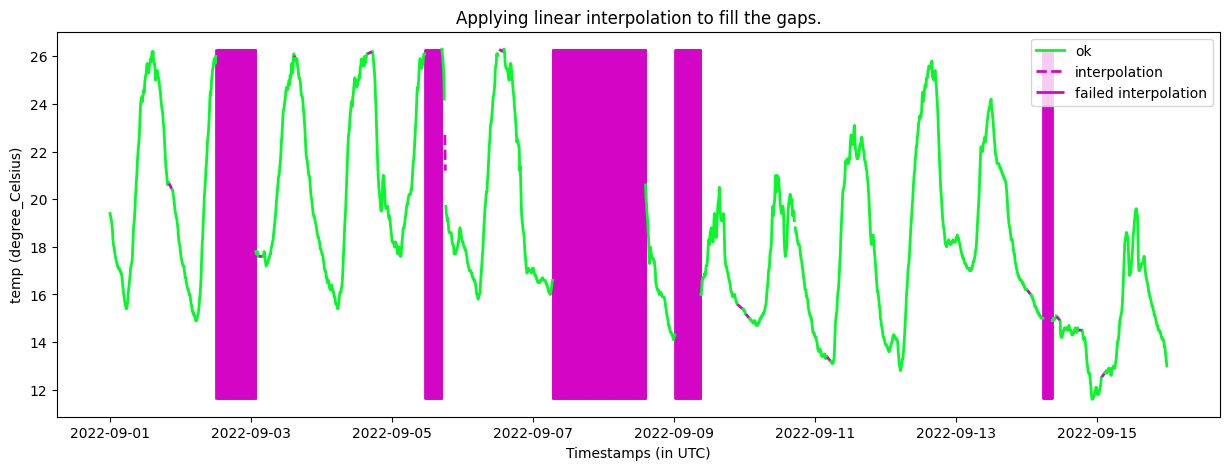

In [8]:
#apply linear interpolation
dataset.get_station('vlinder02').interpolate_gaps(
                    target_obstype='temp', #Which gaps to fill
                    overwrite_fill = True, #Overwrite previous filled values if they are present
                    method='linear', #which interpolation method
                    #Limitations:
                    max_consec_fill=10, #maximum number of consecutive missing records to fill.
                    )
#make a plot
dataset.get_station('vlinder02').make_plot(
                    obstype='temp',
                    colorby='label',
                    title='Applying linear interpolation to fill the gaps.')

As you can see, some (small) gaps are filled others are not filled. This is because a filling criteria was not matched (i.g. `max_consec_fill=10` will only fill gaps with a gapsize of 100 minutes (for 10min resolution)).

By looking at the ``.gapsdf`` , it becomes clear why some gaps could not be filled.

In [9]:
dataset.get_station('vlinder02').gapsdf

,,value,label,details
datetime,obstype,,,
2022-09-01 20:10:00+00:00,temp,20.657143,interpolation,Successful interpolation
2022-09-01 20:20:00+00:00,temp,20.614286,interpolation,Successful interpolation
2022-09-01 20:30:00+00:00,temp,20.571428,interpolation,Successful interpolation
2022-09-01 20:40:00+00:00,temp,20.528572,interpolation,Successful interpolation
2022-09-01 20:50:00+00:00,temp,20.485714,interpolation,Successful interpolation
...,...,...,...,...
2022-09-15 01:50:00+00:00,temp,12.557143,interpolation,Successful interpolation
2022-09-15 02:00:00+00:00,temp,12.585714,interpolation,Successful interpolation
2022-09-15 02:10:00+00:00,temp,12.614285,interpolation,Successful interpolation


### Higher order interpolation demo

When using more advanced interpolation methods, often multiple **anchors** (= the good records that serve as anchor points for the interpolation) are required. In the toolkit we will refer to a **leading period** and a **trailing period**, the anchor's observations before and after the gaps respectively. 

Here is an example on applying a polynomial interpolation on gaps.

<Axes: title={'center': 'linear interpolation (small gaps) +  3th-order-polynomial (for medium gaps)'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

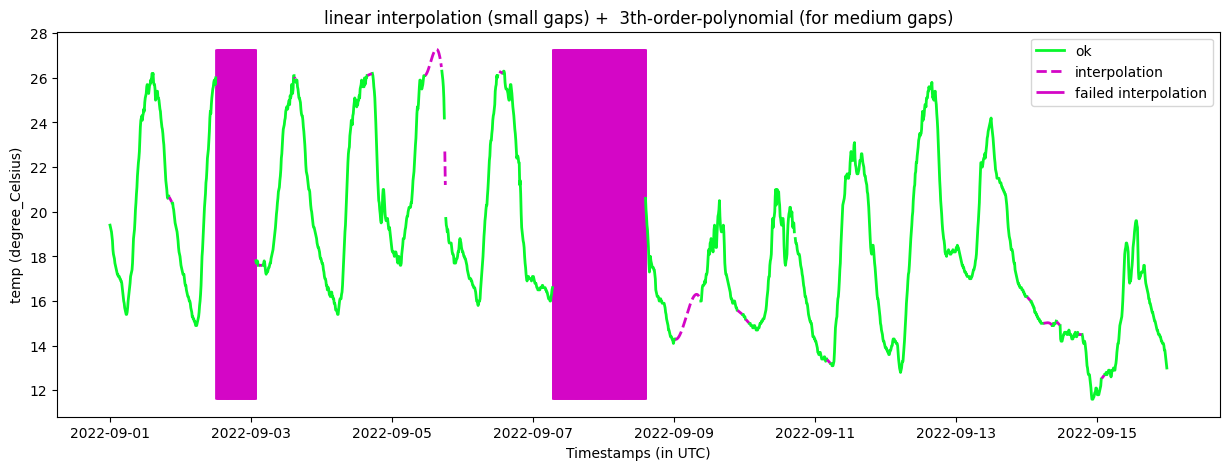

In [10]:
#apply polynomial interpolation 
dataset.get_station('vlinder02').interpolate_gaps(
                  target_obstype='temp',
                  method='polynomial',
                  overwrite_fill=False, #the gaps that are already filled are skipped (i.g. chainig GF methods)
                  n_leading_anchors=3, #at least 3 leading anchors are needed for 3th order polynomial interpolation
                  n_trailing_anchors=4, #at least 3 trailing anchors are needed for 3th order polynomial interpolation
                  max_consec_fill=80, 
                  max_lead_to_gap_distance='60min', #the maximum distance (in time) beween the leading anchors and the start of the gap.
                  method_kwargs={'order':3}, #all extra arguments to pass to the pandas.Dataframe.interpolate method.
)
#make plot
dataset.get_station('vlinder02').make_plot(
                  obstype='temp',
                  colorby='label',
                  title='linear interpolation (small gaps) +  3th-order-polynomial (for medium gaps)')

## Fill gaps using external modeldata

Another technique is to use an external source to fill the gaps. In the metobs-toolkit multiple variants of this technique are implemented, from simple to most complex:

* `.fill_gaps_with_raw_modeldata`
* `.fill_gaps_with_debiased_modeldata`
* `.fill_gaps_with_diurnal_debiased_modeldata`
* `.fill_gaps_with_weighted_diurnal_debias_modeldata`

In general all methods use external modeldata and the more complex the method, the more complex the correction on the external modeldata is.

For a detailed description we refer to the API documentation. 


As an example we will demonstrate the use of the `.fill_gaps_with_debiased_modeldata` method. To start, we need to extract external modeldata. We will extract ERA5-land temperature data, as is demonstrated in the [GEE example](gee_example.ipynb).


In [11]:
#Extract ERA5 temperature modedata 
era5_manager = metobs_toolkit.default_GEE_datasets['ERA5-land']
#Extract the timeseries 
era5_temp = dataset.get_station('vlinder02').get_gee_timeseries_data(
                geedynamicdatasetmanager=era5_manager, #The datasetmanager to use
                startdt_utc=None,
                enddt_utc=None,
                target_obstypes=['temp'], #the observationtypes to extract, must be known modelobstypes
                force_direct_transfer=True
                )

<Axes: title={'center': 'Partially interpolated timeseries and raw ERA5 temperature data.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

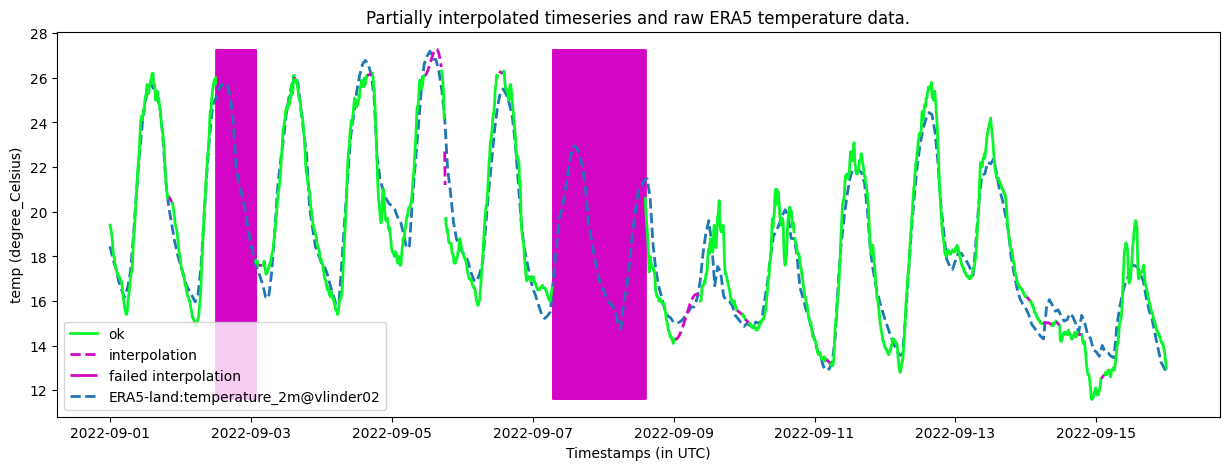

In [12]:
#Make a plot for illustration
dataset.get_station('vlinder02').make_plot(
                obstype='temp',
                colorby='label',
                show_modeldata=True,
                title='Partially interpolated timeseries and raw ERA5 temperature data.')

As we can see, we have external modeldata over the same period as the observations so we can use it to fill the gaps. In the `.fill_gaps_with_debiased_modeldata`, we specify a *leading-* and *trailing period* (a adjacent period before and after the gap with good records). These periods will be used to compute a modelbias, for which the gapfill values will be corrected for. 

In [13]:
import pandas as pd
#Fill the gaps with debias modeldata
dataset.get_station('vlinder02').fill_gaps_with_debiased_modeldata(
            target_obstype='temp',
            leading_period_duration=pd.Timedelta('4h'),
            min_leading_records_total=20,
            trailing_period_duration=pd.Timedelta('4h'),
            min_trailing_records_total=20)



<Axes: title={'center': 'Partially interpolated timeseries and partially filled with debiased ERA5 temperature data.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

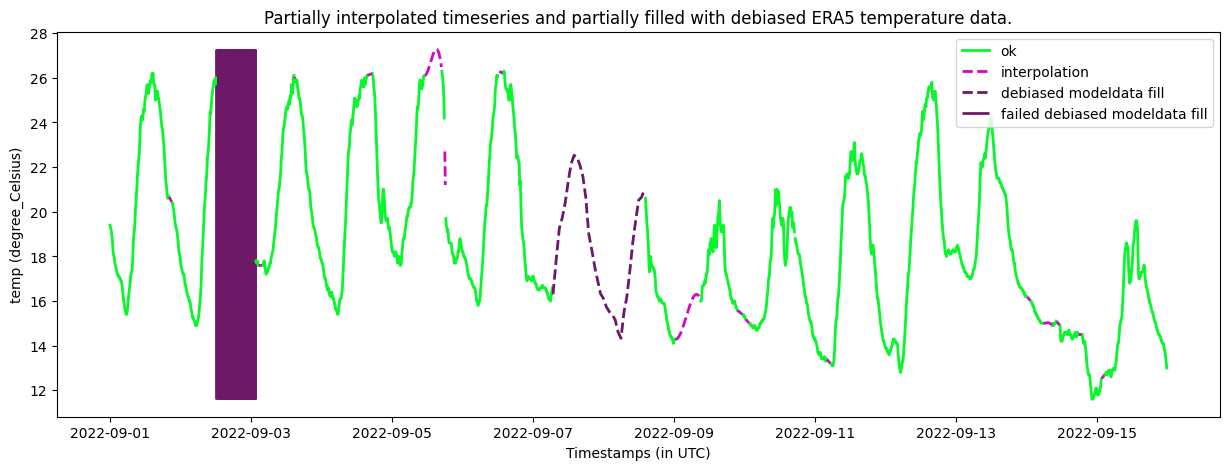

In [14]:
#Make a plot for illustration
dataset.get_station('vlinder02').make_plot(
                obstype='temp',
                colorby='label',
                show_modeldata=False,
                title='Partially interpolated timeseries and partially filled with debiased ERA5 temperature data.')

As you can see, one of the remaining gaps is successfully filled with the debiased modeldata. One gap is not filled, to see why we inspect the `.modeldf` attribute.

In [15]:
dataset.get_station('vlinder02').gapsdf

,,value,label,details
datetime,obstype,,,
2022-09-01 20:10:00+00:00,temp,20.657143,interpolation,Successful interpolation
2022-09-01 20:20:00+00:00,temp,20.614286,interpolation,Successful interpolation
2022-09-01 20:30:00+00:00,temp,20.571428,interpolation,Successful interpolation
2022-09-01 20:40:00+00:00,temp,20.528572,interpolation,Successful interpolation
2022-09-01 20:50:00+00:00,temp,20.485714,interpolation,Successful interpolation
...,...,...,...,...
2022-09-15 01:50:00+00:00,temp,12.557143,interpolation,Successful interpolation
2022-09-15 02:00:00+00:00,temp,12.585714,interpolation,Successful interpolation
2022-09-15 02:10:00+00:00,temp,12.614285,interpolation,Successful interpolation


We see that the issue is too few trailing records (17 found but 20 required in a 4-hour period). You can verify this by looking in the `.df` attribute of the station to see that this is true. You can also see this in the timeseries plot if you zoom in to the trailing period, that there is a interpolated gap (insert `%matplotlib qt` in the cell with the `.make_plot()` call to use the zoom-tool.)


Note that successful interpolated records are not included in the trailing period.

In order to solve this, we can lessen the restriction for the trailing period.

<Axes: title={'center': 'Partially interpolated timeseries and partially filled with debiased ERA5 temperature data.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

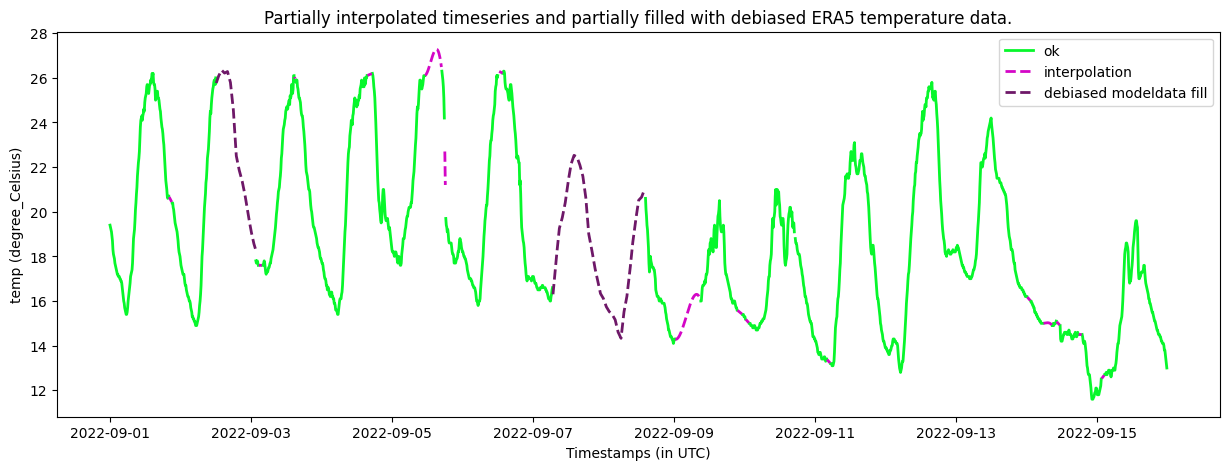

In [16]:


#Fill the gaps with debias modeldata
dataset.get_station('vlinder02').fill_gaps_with_debiased_modeldata(
            target_obstype='temp',
            leading_period_duration=pd.Timedelta('4h'),
            min_leading_records_total=20,
            trailing_period_duration=pd.Timedelta('4h'),
            min_trailing_records_total=15) #lessened restriction 20 -> 15

#Make a plot for illustration
dataset.get_station('vlinder02').make_plot(
                obstype='temp',
                colorby='label',
                show_modeldata=False,
                title='Partially interpolated timeseries and partially filled with debiased ERA5 temperature data.')